<a href="https://colab.research.google.com/github/ariahosseini/DeepML/blob/main/017_PyTorch_Proj_Seventeen_GNN_DGL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install  dgl -f https://data.dgl.ai/wheels/repo.html
!pip install  dglgo -f https://data.dgl.ai/wheels-test/repo.html

# Utils

In [ ]:
import os
os.environ["DGLBACKEND"] = "pytorch"

In [ ]:
# util
import math
import random
import os, sys, itertools
import time
import argparse
import multiprocessing
import urllib.request

import tqdm
import pandas as pd
import numpy as np
import scipy.sparse as sp
from functools import partial, reduce, wraps
from tqdm.auto import tqdm
from tqdm import tqdm
from functools import partial
from collections import defaultdict
from gensim.models.keyedvectors import Vocab
from six import iteritems
# sklearn
from sklearn.metrics import (roc_auc_score, accuracy_score, auc,
                             f1_score, precision_recall_curve)
from sklearn.model_selection import StratifiedKFold
# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as func
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
# graph
import networkx as nx
import dgl
import dgl.graphbolt as gb
import dgl.function as fn
from dgl.data import GINDataset, DGLDataset
from dgl.dataloading import GraphDataLoader
from dgl.nn import GraphConv, SAGEConv
from dgl.nn.pytorch.conv import GINConv
from dgl.nn.pytorch.glob import SumPooling
# visual
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.environ['TORCH'] = torch.__version__

In [ ]:
if torch.cuda.is_available():
    device = "cuda" # use NVIDIA GPU (if available)
elif torch.backends.mps.is_available():
    device = "mps" # use Apple Silicon GPU (if available)
else:
    device = "cpu" # default to CPU if no GPU is available

In [ ]:
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
from torchinfo import summary

# Node Classification

In [ ]:
# dataset
dataset = dgl.data.CoraGraphDataset()

/root/.dgl/cora_v2.zip:   0%|          | 0.00/132k [00:00<?, ?B/s]

Extracting file to /root/.dgl/cora_v2_d697a464
Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.


In [ ]:
print("Number of graphs:", len(dataset))

Number of graphs: 1


In [ ]:
# graph
graph = dataset[0]

In [ ]:
print("Node features")
print(graph.ndata)
print("Edge features")
print(graph.edata)

Node features
{'train_mask': tensor([ True,  True,  True,  ..., False, False, False]), 'val_mask': tensor([False, False, False,  ..., False, False, False]), 'test_mask': tensor([False, False, False,  ...,  True,  True,  True]), 'label': tensor([3, 4, 4,  ..., 3, 3, 3]), 'feat': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])}
Edge features
{}


In [ ]:
class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)
    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = func.relu(h)
        h = self.conv2(g, h)
        return h

In [ ]:
def train(gr, model):
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    best_val_acc = 0
    best_test_acc = 0
    features = graph.ndata["feat"]
    labels = graph.ndata["label"]
    train_mask = graph.ndata["train_mask"]
    val_mask = graph.ndata["val_mask"]
    test_mask = graph.ndata["test_mask"]
    for e in range(101):
        logits = model(gr, features) # forward
        pred = logits.argmax(1) # compute prediction
        loss = func.cross_entropy(logits[train_mask], labels[train_mask]) # compute loss
        # compute accuracy on training/validation/test
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()
        if best_val_acc < val_acc:
          best_val_acc = val_acc # best validation
          best_test_acc = test_acc # corresponding test accuracy
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if e%20 == 0:
            print(f"In epoch {e}, loss: {loss:.3f}, val acc: {val_acc:.3f} (best {best_val_acc:.3f}), test acc: {test_acc:.3f} (best {best_test_acc:.3f})")

In [ ]:
# create the model with given dimensions
model = GCN(graph.ndata["feat"].shape[1], 16, dataset.num_classes)

In [ ]:
summary(model=model)

Layer (type:depth-idx)                   Param #
GCN                                      --
├─GraphConv: 1-1                         22,944
├─GraphConv: 1-2                         119
Total params: 23,063
Trainable params: 23,063
Non-trainable params: 0

In [ ]:
train(graph, model)

In epoch 0, loss: 1.940, val acc: 0.150 (best 0.150), test acc: 0.174 (best 0.174)
In epoch 20, loss: 1.540, val acc: 0.606 (best 0.606), test acc: 0.623 (best 0.623)
In epoch 40, loss: 0.907, val acc: 0.732 (best 0.732), test acc: 0.739 (best 0.739)
In epoch 60, loss: 0.415, val acc: 0.764 (best 0.764), test acc: 0.763 (best 0.763)
In epoch 80, loss: 0.187, val acc: 0.772 (best 0.772), test acc: 0.777 (best 0.774)
In epoch 100, loss: 0.096, val acc: 0.768 (best 0.772), test acc: 0.770 (best 0.774)


In [ ]:
for name, param in model.named_parameters():
    if param.grad is not None:
        print(name, param.grad)

conv1.weight tensor([[ 4.3620e-06, -9.5856e-07,  4.8928e-06,  ..., -2.5690e-06,
         -2.1256e-06,  1.7325e-06],
        [-3.9137e-05,  2.6413e-05,  6.2629e-05,  ...,  5.6700e-06,
          1.6510e-05, -8.4654e-06],
        [ 1.6541e-05,  4.7706e-06, -2.5239e-06,  ..., -1.1444e-05,
          8.1274e-06,  2.9964e-05],
        ...,
        [ 4.4795e-06,  6.5537e-06,  6.5312e-06,  ..., -1.2038e-05,
         -3.8341e-06, -6.6567e-06],
        [ 8.7922e-06,  4.3539e-07,  1.6204e-05,  ..., -1.2503e-05,
         -3.0691e-05, -2.9384e-05],
        [-9.2137e-06, -4.8213e-06,  1.3109e-05,  ...,  9.7941e-06,
         -5.4078e-06,  2.5396e-06]])
conv1.bias tensor([-2.5215e-03, -3.2461e-04, -1.5162e-03, -5.3790e-04, -3.9194e-03,
        -7.7308e-05,  2.6398e-04, -6.1865e-04, -7.7050e-04, -2.9080e-03,
        -1.4211e-03, -6.8168e-04,  4.6984e-04, -8.6706e-04, -2.1759e-04,
        -6.1422e-04])
conv2.weight tensor([[ 0.0049, -0.0029, -0.0018, -0.0021,  0.0026, -0.0005, -0.0002],
        [-0.0016,

# DGL Graph Representation

In [ ]:
graph = dgl.graph(([0, 0, 0, 0, 0], [1, 2, 3, 4, 5]), num_nodes=6)
graph.ndata["x"] = torch.randn(6, 3) # assign a 3-dimensional node feature vector for each node
graph.ndata["y"] = torch.randn(6, 5, 4) # assign a 5x4 node feature matrix for each node
graph.edata["a"] = torch.randn(5, 4) # assign a 4-dimensional edge feature vector for each edge

In [ ]:
print(graph.edata)

{'a': tensor([[-0.7597,  0.1666,  0.2882,  0.9317],
        [-0.2731, -0.7164, -1.1395, -2.6688],
        [ 1.5812, -1.3539,  0.6563,  1.5207],
        [ 0.0222, -1.3592,  0.9294,  0.3498],
        [ 0.7542, -0.9402,  1.3791, -0.6899]])}


In [ ]:
print(graph.ndata)

{'x': tensor([[ 1.2560, -0.0398, -0.2730],
        [ 0.5024, -0.1735,  0.9923],
        [ 1.0957, -0.8739, -1.2375],
        [-0.2404,  0.1506,  1.4728],
        [ 0.4652,  0.5377, -1.6812],
        [ 1.9863,  0.2965,  0.9501]]), 'y': tensor([[[-0.2589, -1.6404,  0.1041,  0.5290],
         [ 0.0296,  1.2908, -0.2452,  0.1767],
         [ 1.2068, -1.2861, -0.3502, -0.1656],
         [ 0.1909,  0.6888,  0.2044, -0.2370],
         [-1.6794,  1.2477, -0.7168, -0.9567]],

        [[ 0.0782,  1.9676,  1.2159,  0.0562],
         [-0.0960, -0.7131, -0.7554, -0.0150],
         [-0.7142,  0.7439,  0.4542,  1.2753],
         [ 0.4011,  0.9091, -0.4937,  1.4777],
         [ 0.4880,  0.8199, -1.0829, -0.2461]],

        [[ 0.0825,  0.6047, -0.1716,  0.3194],
         [-0.3651, -0.6832,  0.2585,  1.0798],
         [-1.0124,  1.3636, -2.1527, -0.2159],
         [ 1.1300,  0.9593,  0.6202, -0.8698],
         [-0.7551, -0.4903, -0.2283,  0.1867]],

        [[-0.1740, -1.1883, -1.6545,  0.7846],
       

In [ ]:
print("Number of nodes:", graph.num_nodes())
print("Number of edges:", graph.num_edges())
print("Out-degrees of the center node:", graph.out_degrees(0))
print("In-degrees of the center node:", graph.in_degrees(0))

Number of nodes: 6
Number of edges: 5
Out-degrees of the center node: 5
In-degrees of the center node: 0


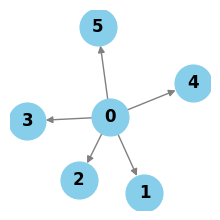

In [ ]:
gr = graph.to_networkx()
pos = nx.spring_layout(gr)  # layout algorithm (spring layout)
plt.figure(figsize=(2,2))
nx.draw(gr, pos, with_labels=True, font_weight='bold', node_size=700, node_color='skyblue', edge_color='gray')
plt.show()

In [ ]:
subgr_one = graph.subgraph([0, 1, 3]) # induce a subgraph from node 0, node 1 and node 3
subgr_two = graph.edge_subgraph([0, 1, 3]) # induce a subgraph from edge 0, edge 1 and edge 3

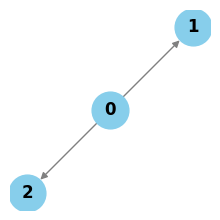

In [ ]:
gr = subgr_one.to_networkx()
pos = nx.spring_layout(gr)
plt.figure(figsize=(2,2))
nx.draw(gr, pos, with_labels=True, font_weight='bold', node_size=700, node_color='skyblue', edge_color='gray')
plt.show()

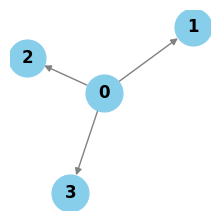

In [ ]:
gr = subgr_two.to_networkx()
pos = nx.spring_layout(gr)
plt.figure(figsize=(2,2))
nx.draw(gr, pos, with_labels=True, font_weight='bold', node_size=700, node_color='skyblue', edge_color='gray')
plt.show()

In [ ]:
print("Original IDs of each node in subgr_one", subgr_one.ndata[dgl.NID])
print("Original IDs of each edge in subgr_one", subgr_one.edata[dgl.EID])
print("Original IDs of each noce in subgr_two", subgr_two.ndata[dgl.NID])
print("Original IDs of each edge in subgr_two", subgr_two.edata[dgl.EID])

Original IDs of each node in subgr_one tensor([0, 1, 3])
Original IDs of each edge in subgr_one tensor([0, 2])
Original IDs of each noce in subgr_two tensor([0, 1, 2, 4])
Original IDs of each edge in subgr_two tensor([0, 1, 3])


In [ ]:
bidir_gr = dgl.add_reverse_edges(graph)
print(bidir_gr.edges())

(tensor([0, 0, 0, 0, 0, 1, 2, 3, 4, 5]), tensor([1, 2, 3, 4, 5, 0, 0, 0, 0, 0]))


# GraphSAGE Conv Implementation

In [ ]:
dataset = dgl.data.CoraGraphDataset()

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [ ]:
g = dataset[0]

In [ ]:
class SAGEConv(nn.Module):
    """Graph convolution module used by the GraphSAGE model.

    Parameters
    ----------
    in_feat : int
        Input feature size.
    out_feat : int
        Output feature size.
    """

    def __init__(self, in_feat, out_feat):
        super(SAGEConv, self).__init__()
        self.linear = nn.Linear(in_feat * 2, out_feat) # project the input and neighbor features to the output.

    def forward(self, g, h):
        """Forward computation.

        Parameters
        ----------
        g : Graph
            The input graph.
        h : Tensor
            The input node feature.
        """
        with g.local_scope():
            g.ndata["h"] = h
            # update_all is a message passing API
            g.update_all(message_func=fn.copy_u("h", "m"), reduce_func=fn.mean("m", "h_N"))
            h_N = g.ndata["h_N"]
            h_total = torch.cat([h, h_N], dim=1)
            return self.linear(h_total)

In [ ]:
class Model(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(Model, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats)
        self.conv2 = SAGEConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = func.relu(h)
        h = self.conv2(g, h)
        return h

In [ ]:
def train(g, model):
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    all_logits = []
    best_val_acc = 0
    best_test_acc = 0
    features = g.ndata["feat"]
    labels = g.ndata["label"]
    train_mask = g.ndata["train_mask"]
    val_mask = g.ndata["val_mask"]
    test_mask = g.ndata["test_mask"]
    for e in range(201):
        logits = model(g, features) # forward
        pred = logits.argmax(1) # prediction
        loss = func.cross_entropy(logits[train_mask], labels[train_mask])
        # compute accuracy on training/validation/test
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()
        # save the best validation accuracy and the corresponding test accuracy
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        all_logits.append(logits.detach())
        if e % 20 == 0:
            print("In epoch {}, loss: {:.3f}, val acc: {:.3f} (best {:.3f}), test acc: {:.3f} (best {:.3f})".format(e, loss, val_acc, best_val_acc, test_acc, best_test_acc))

In [ ]:
model = Model(g.ndata["feat"].shape[1], 16, dataset.num_classes)
train(g, model)

In epoch 0, loss: 1.951, val acc: 0.316 (best 0.316), test acc: 0.319 (best 0.319)
In epoch 20, loss: 1.356, val acc: 0.482 (best 0.586), test acc: 0.459 (best 0.566)
In epoch 40, loss: 0.388, val acc: 0.750 (best 0.750), test acc: 0.744 (best 0.744)
In epoch 60, loss: 0.068, val acc: 0.742 (best 0.756), test acc: 0.755 (best 0.752)
In epoch 80, loss: 0.022, val acc: 0.748 (best 0.756), test acc: 0.755 (best 0.752)
In epoch 100, loss: 0.013, val acc: 0.746 (best 0.756), test acc: 0.752 (best 0.752)
In epoch 120, loss: 0.009, val acc: 0.746 (best 0.756), test acc: 0.751 (best 0.752)
In epoch 140, loss: 0.007, val acc: 0.744 (best 0.756), test acc: 0.751 (best 0.752)
In epoch 160, loss: 0.005, val acc: 0.742 (best 0.756), test acc: 0.752 (best 0.752)
In epoch 180, loss: 0.004, val acc: 0.740 (best 0.756), test acc: 0.751 (best 0.752)
In epoch 200, loss: 0.003, val acc: 0.740 (best 0.756), test acc: 0.754 (best 0.752)


# Weighted GraphSAGE Conv Implementation

In [ ]:
dataset = dgl.data.CoraGraphDataset()
g = dataset[0]

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [ ]:
class WeightedSAGEConv(nn.Module):
    """Graph convolution module used by the GraphSAGE model with edge weights.

    Parameters
    ----------
    in_feat : int
        Input feature size.
    out_feat : int
        Output feature size.
    """

    def __init__(self, in_feat, out_feat):
        super(WeightedSAGEConv, self).__init__()
        # a linear submodule for projecting the input and neighbor feature to the output
        self.linear = nn.Linear(in_feat*2, out_feat)

    def forward(self, g, h, w):
        """Forward computation

        Parameters
        ----------
        g : Graph
            The input graph.
        h : Tensor
            The input node feature.
        w : Tensor
            The edge weight.
        """
        with g.local_scope():
            g.ndata["h"] = h
            g.edata["w"] = w
            g.update_all(message_func=fn.u_mul_e("h", "w", "m"),reduce_func=fn.mean("m", "h_N"))
            h_N = g.ndata["h_N"]
            h_total = torch.cat([h, h_N], dim=1)
            return self.linear(h_total)

In [ ]:
class Model(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(Model, self).__init__()
        self.conv1 = WeightedSAGEConv(in_feats, h_feats)
        self.conv2 = WeightedSAGEConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat, torch.ones(g.num_edges(), 1).to(g.device))
        h = func.relu(h)
        h = self.conv2(g, h, torch.ones(g.num_edges(), 1).to(g.device))
        return h

In [ ]:
def train(g, model):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    all_logits = []
    best_val_acc = 0
    best_test_acc = 0
    features = g.ndata["feat"]
    labels = g.ndata["label"]
    train_mask = g.ndata["train_mask"]
    val_mask = g.ndata["val_mask"]
    test_mask = g.ndata["test_mask"]
    for e in range(201):
        logits = model(g, features) # forward
        pred = logits.argmax(1) # prediction
        loss = func.cross_entropy(logits[train_mask], labels[train_mask])
        # compute accuracy on training/validation/test
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()
        # save the best validation accuracy and the corresponding test accuracy
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        all_logits.append(logits.detach())
        if e % 20 == 0:
            print("In epoch {}, loss: {:.3f}, val acc: {:.3f} (best {:.3f}), test acc: {:.3f} (best {:.3f})".format(e, loss, val_acc, best_val_acc, test_acc, best_test_acc))

In [ ]:
model = Model(g.ndata["feat"].shape[1], 16, dataset.num_classes)
train(g, model)

torch.Size([10556, 1]) torch.Size([2708, 1433])
torch.Size([10556, 1]) torch.Size([2708, 16])
In epoch 0, loss: 1.953, val acc: 0.316 (best 0.316), test acc: 0.319 (best 0.319)


# Link Prediction

In [ ]:
dataset = dgl.data.CoraGraphDataset()

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [ ]:
graph = dataset[0]

In [ ]:
u, v = graph.edges() # split edge set for training and testing
eids = np.arange(graph.num_edges())
eids = np.random.permutation(eids)
test_size = int(len(eids) * 0.1)
train_size = graph.num_edges() - test_size
test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]
# find all negative edges and split them for training and testing
adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))
adj_neg = 1 - adj.todense() - np.eye(graph.num_nodes())
neg_u, neg_v = np.where(adj_neg!=0)
neg_eids = np.random.choice(len(neg_u), graph.num_edges())
test_neg_u, test_neg_v = (
    neg_u[neg_eids[:test_size]],
    neg_v[neg_eids[:test_size]],
    )
train_neg_u, train_neg_v = (
    neg_u[neg_eids[test_size:]],
    neg_v[neg_eids[test_size:]],
    )

In [ ]:
train_graph = dgl.remove_edges(graph, eids[:test_size]) # remove the edges in the test set from the original graph

In [ ]:
# build a two-layer GraphSAGE model
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, "mean")
        self.conv2 = SAGEConv(h_feats, h_feats, "mean")

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = func.relu(h)
        h = self.conv2(g, h)
        return h

In [ ]:
# positive and negative graphs
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=graph.num_nodes())
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=graph.num_nodes())
test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=graph.num_nodes())
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=graph.num_nodes())

In [ ]:
class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata["h"] = h
            # compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v("h", "h", "score"))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata["score"][:, 0]

class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, 1)

    def apply_edges(self, edges):
        """
        Computes a scalar score for each edge of the given graph

        Parameters
        ----------
        edges :
            Has three members ``src``, ``dst`` and ``data``, each of
            which is a dictionary representing the features of the
            source nodes, the destination nodes, and the edges
            themselves

        Returns
        -------
        dict
            A dictionary of new edge features.
        """
        h = torch.cat([edges.src["h"], edges.dst["h"]], 1)
        return {"score": self.W2(func.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata["h"] = h
            g.apply_edges(self.apply_edges)
            return g.edata["score"]

In [ ]:
model = GraphSAGE(train_graph.ndata["feat"].shape[1], 16)
pred = DotPredictor() # replace DotPredictor with MLPPredictor as pred = MLPPredictor(16)

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]
        )
    return func.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]
    ).numpy()
    return roc_auc_score(labels, scores)

In [ ]:
optimizer = optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)
all_logits = []
for e in range(101):
    # forward
    h = model(train_graph, train_graph.ndata["feat"])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)
    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e%20==0:
        print("In epoch {}, loss: {}".format(e, loss))

with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    print("AUC", compute_auc(pos_score, neg_score))

In epoch 0, loss: 0.6983332633972168
In epoch 20, loss: 0.5125433802604675
In epoch 40, loss: 0.4140874743461609
In epoch 60, loss: 0.32917582988739014
In epoch 80, loss: 0.24367840588092804
In epoch 100, loss: 0.1606931835412979
AUC 0.8633184339974393


# Graph Classification

In [ ]:
# a synthetic dataset with 10000 graphs, ranging from 10 to 500 nodes.
dataset = dgl.data.GINDataset("PROTEINS", self_loop=True)

/root/.dgl/GINDataset.zip: 100%|██████████| 33.4M/33.4M [00:00<00:00, 37.2MB/s]


Extracting file to /root/.dgl/GINDataset


In [ ]:
print("Node feature dimensionality:", dataset.dim_nfeats)
print("Number of graph categories:", dataset.gclasses)

Node feature dimensionality: 3
Number of graph categories: 2


In [ ]:
num_examples = len(dataset)
num_train = int(num_examples * 0.8)
train_sampler = SubsetRandomSampler(torch.arange(num_train))
test_sampler = SubsetRandomSampler(torch.arange(num_train, num_examples))
train_dataloader = GraphDataLoader(dataset, sampler=train_sampler, batch_size=5, drop_last=False)
test_dataloader = GraphDataLoader(dataset, sampler=test_sampler, batch_size=5, drop_last=False)

In [ ]:
it = iter(train_dataloader)
batch = next(it)
print(batch)

[Graph(num_nodes=148, num_edges=700,
      ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'attr': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={}), tensor([0, 0, 0, 0, 0])]


In [ ]:
batched_graph, labels = batch
print(
    "Number of nodes for each graph element in the batch:",
    batched_graph.batch_num_nodes(),
    )
print(
    "Number of edges for each graph element in the batch:",
    batched_graph.batch_num_edges(),
    )
# recover the original graph elements from the minibatch
graphs = dgl.unbatch(batched_graph)
print("The original graphs in the minibatch:")
print(graphs)

Number of nodes for each graph element in the batch: tensor([35,  9, 32, 55, 17])
Number of edges for each graph element in the batch: tensor([175,  45, 144, 263,  73])
The original graphs in the minibatch:
[Graph(num_nodes=35, num_edges=175,
      ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'attr': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={}), Graph(num_nodes=9, num_edges=45,
      ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'attr': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={}), Graph(num_nodes=32, num_edges=144,
      ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'attr': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={}), Graph(num_nodes=55, num_edges=263,
      ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'attr': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={}), Graph(num_nodes=17, num_edges=73,
      ndata_schemes={'label': Scheme(shape=(), dtype=tor

In [ ]:
class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = func.relu(h)
        h = self.conv2(g, h)
        g.ndata["h"] = h
        return dgl.mean_nodes(g, "h")

In [ ]:
# create the model with given dimensions
model = GCN(dataset.dim_nfeats, 16, dataset.gclasses)
optimizer = optim.Adam(model.parameters(), lr=0.01)
for epoch in range(20):
    for batched_graph, labels in train_dataloader:
        pred = model(batched_graph, batched_graph.ndata["attr"].float())
        loss = func.cross_entropy(pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
num_correct = 0
num_tests = 0
for batched_graph, labels in test_dataloader:
    pred = model(batched_graph, batched_graph.ndata["attr"].float())
    num_correct += (pred.argmax(1) == labels).sum().item()
    num_tests += len(labels)
print("Test accuracy:", num_correct / num_tests)

Test accuracy: 0.2914798206278027


# Graph Isomorphism Network (GIN)

In [ ]:
class MLP(nn.Module):
    """construct two-layer MLP-type aggreator for GIN model"""
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.linears = nn.ModuleList()
        # two-layer mlp
        self.linears.append(nn.Linear(input_dim, hidden_dim, bias=False))
        self.linears.append(nn.Linear(hidden_dim, output_dim, bias=False))
        self.batch_norm = nn.BatchNorm1d((hidden_dim))
    def forward(self, x):
        h = x
        h = func.relu(self.batch_norm(self.linears[0](h)))
        return self.linears[1](h)

In [ ]:
class GIN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.ginlayers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        num_layers = 5
        # five-layer GCN with two-layer MLP aggregator and sum-neighbor-pooling scheme
        for layer in range(num_layers - 1):  # excluding the input layer
            if layer == 0:
                mlp = MLP(input_dim, hidden_dim, hidden_dim)
            else:
                mlp = MLP(hidden_dim, hidden_dim, hidden_dim)
            self.ginlayers.append(
                GINConv(mlp, learn_eps=False)
                )  # set to True if learning epsilon
            self.batch_norms.append(nn.BatchNorm1d(hidden_dim))
        # linear functions for graph sum poolings of output of each layer
        self.linear_prediction = nn.ModuleList()
        for layer in range(num_layers):
            if layer == 0:
                self.linear_prediction.append(nn.Linear(input_dim, output_dim))
            else:
                self.linear_prediction.append(nn.Linear(hidden_dim, output_dim))
        self.drop = nn.Dropout(0.5)
        self.pool = (SumPooling())  # change to mean readout (AvgPooling) on social network datasets

    def forward(self, g, h):
        # list of hidden representation at each layer (including the input layer)
        hidden_rep = [h]
        for i, layer in enumerate(self.ginlayers):
            h = layer(g, h)
            h = self.batch_norms[i](h)
            h = func.relu(h)
            hidden_rep.append(h)
        score_over_layer = 0
        # perform graph sum pooling over all nodes in each layer
        for i, h in enumerate(hidden_rep):
            pooled_h = self.pool(g, h)
            score_over_layer += self.drop(self.linear_prediction[i](pooled_h))
        return score_over_layer

In [ ]:
def split_fold10(labels, fold_idx=0):
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    idx_list = []
    for idx in skf.split(np.zeros(len(labels)), labels):
        idx_list.append(idx)
    train_idx, valid_idx = idx_list[fold_idx]
    return train_idx, valid_idx

In [ ]:
def evaluate(dataloader, model):
    model.eval()
    total = 0
    total_correct = 0
    for batched_graph, labels in dataloader:
        batched_graph = batched_graph
        labels = labels
        feat = batched_graph.ndata.pop("attr")
        total += len(labels)
        logits = model(batched_graph, feat)
        _, predicted = torch.max(logits, 1)
        total_correct += (predicted == labels).sum().item()
    acc = 1.0 * total_correct / total
    return acc

In [ ]:
def train(train_loader, val_loader, model):
    # loss function, optimizer and scheduler
    loss_fcn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
    # training loop
    for epoch in range(10):
        model.train()
        total_loss = 0
        for batch, (batched_graph, labels) in enumerate(train_loader):
            batched_graph = batched_graph
            labels = labels
            feat = batched_graph.ndata.pop("attr")
            logits = model(batched_graph, feat)
            loss = loss_fcn(logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        scheduler.step()
        train_acc = evaluate(train_loader, model)
        valid_acc = evaluate(val_loader, model)
        print("Epoch {:05d} | Loss {:.4f} | Train Acc. {:.4f} | Validation Acc. {:.4f} ".format(
            epoch, total_loss / (batch + 1), train_acc, valid_acc))

In [ ]:
dataset = "MUTAG"
dataset = GINDataset(dataset, self_loop=True, degree_as_nlabel=False)  # add self_loop and disable one-hot encoding for input features
labels = [l for _, l in dataset]
train_idx, val_idx = split_fold10(labels)
# create dataloader
train_loader = GraphDataLoader(
    dataset, sampler=SubsetRandomSampler(train_idx),
    batch_size=128, pin_memory=torch.cuda.is_available(),
    )
val_loader = GraphDataLoader(
    dataset, sampler=SubsetRandomSampler(val_idx),
    batch_size=128, pin_memory=torch.cuda.is_available(),
    )
# create GIN model
in_size = dataset.dim_nfeats
out_size = dataset.gclasses
model = GIN(in_size, 16, out_size)
# model training/validating
print("Training...")
train(train_loader, val_loader, model)

/root/.dgl/GINDataset.zip: 100%|██████████| 33.4M/33.4M [00:00<00:00, 57.0MB/s]


Extracting file to /root/.dgl/GINDataset
Training...
Epoch 00000 | Loss 7.9970 | Train Acc. 0.6746 | Validation Acc. 0.7368 
Epoch 00001 | Loss 2.5250 | Train Acc. 0.6627 | Validation Acc. 0.6842 
Epoch 00002 | Loss 2.5683 | Train Acc. 0.6627 | Validation Acc. 0.6842 
Epoch 00003 | Loss 2.8745 | Train Acc. 0.6627 | Validation Acc. 0.6842 
Epoch 00004 | Loss 2.7105 | Train Acc. 0.6627 | Validation Acc. 0.6842 
Epoch 00005 | Loss 1.7668 | Train Acc. 0.6627 | Validation Acc. 0.6842 
Epoch 00006 | Loss 1.4262 | Train Acc. 0.6627 | Validation Acc. 0.6842 
Epoch 00007 | Loss 1.4870 | Train Acc. 0.6627 | Validation Acc. 0.6842 
Epoch 00008 | Loss 1.1107 | Train Acc. 0.6627 | Validation Acc. 0.6842 
Epoch 00009 | Loss 1.0967 | Train Acc. 0.6627 | Validation Acc. 0.6842 


# Make Dataset

###  Dataset for Node Classification or Link Prediction from CSV

In [ ]:
urllib.request.urlretrieve("https://data.dgl.ai/tutorial/dataset/members.csv", "./members.csv")
urllib.request.urlretrieve("https://data.dgl.ai/tutorial/dataset/interactions.csv", "./interactions.csv")


('./interactions.csv', <http.client.HTTPMessage at 0x79f043b27b50>)

In [ ]:
members = pd.read_csv("./members.csv") # the attributes of all members
members.head()

,Id,Club,Age
0,0,Mr. Hi,44
1,1,Mr. Hi,37
2,2,Mr. Hi,37
3,3,Mr. Hi,40
4,4,Mr. Hi,30


In [ ]:
interactions = pd.read_csv("./interactions.csv") # the pair-wise interactions between two club members
interactions.head()

,Src,Dst,Weight
0,0,1,0.043591
1,0,2,0.282119
2,0,3,0.370293
3,0,4,0.730570
4,0,5,0.821187


In [ ]:
members.Club.unique()

array(['Mr. Hi', 'Officer'], dtype=object)

In [ ]:
class KarateClubDataset(DGLDataset):
    def __init__(self):
        super().__init__(name="karate_club")

    def process(self):
        nodes_data = pd.read_csv("./members.csv")
        edges_data = pd.read_csv("./interactions.csv")
        node_features = torch.from_numpy(nodes_data["Age"].to_numpy())
        node_labels = torch.from_numpy(
            nodes_data["Club"].astype("category").cat.codes.to_numpy()
            )
        edge_features = torch.from_numpy(edges_data["Weight"].to_numpy())
        edges_src = torch.from_numpy(edges_data["Src"].to_numpy())
        edges_dst = torch.from_numpy(edges_data["Dst"].to_numpy())
        self.graph = dgl.graph(
            (edges_src, edges_dst), num_nodes=nodes_data.shape[0]
            )
        self.graph.ndata["feat"] = node_features
        self.graph.ndata["label"] = node_labels
        self.graph.edata["weight"] = edge_features
        # if the dataset is a node classification dataset, one needs to assign
        # masks indicating whether a node belongs to training, validation, and test set
        n_nodes = nodes_data.shape[0]
        n_train = int(n_nodes * 0.6)
        n_val = int(n_nodes * 0.2)
        train_mask = torch.zeros(n_nodes, dtype=torch.bool)
        val_mask = torch.zeros(n_nodes, dtype=torch.bool)
        test_mask = torch.zeros(n_nodes, dtype=torch.bool)
        train_mask[:n_train] = True
        val_mask[n_train : n_train + n_val] = True
        test_mask[n_train + n_val :] = True
        self.graph.ndata["train_mask"] = train_mask
        self.graph.ndata["val_mask"] = val_mask
        self.graph.ndata["test_mask"] = test_mask

    def __getitem__(self, i):
        return self.graph

    def __len__(self):
        return 1

In [ ]:
dataset = KarateClubDataset()
graph = dataset[0]
print(graph)

Graph(num_nodes=34, num_edges=156,
      ndata_schemes={'feat': Scheme(shape=(), dtype=torch.int64), 'label': Scheme(shape=(), dtype=torch.int8), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float64)})


<ipython-input-17-5db7c809ca09>:9: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  node_labels = torch.from_numpy(


### Dataset for Graph Classification from CSV

In [ ]:
urllib.request.urlretrieve(
    "https://data.dgl.ai/tutorial/dataset/graph_edges.csv", "./graph_edges.csv"
    )
urllib.request.urlretrieve(
    "https://data.dgl.ai/tutorial/dataset/graph_properties.csv",
    "./graph_properties.csv"
    )

('./graph_properties.csv', <http.client.HTTPMessage at 0x79f05bf33df0>)

In [ ]:
edges = pd.read_csv("./graph_edges.csv")
edges.head()

,graph_id,src,dst
0,0,0,1
1,0,0,14
2,0,1,0
3,0,1,2
4,0,2,1


In [ ]:
properties = pd.read_csv("./graph_properties.csv")
properties.head()

,graph_id,label,num_nodes
0,0,0,15
1,1,0,10
2,2,0,13
3,3,0,13
4,4,0,17


In [ ]:
class SyntheticDataset(DGLDataset):
    def __init__(self):
        super().__init__(name="synthetic")

    def process(self):
        edges = pd.read_csv("./graph_edges.csv")
        properties = pd.read_csv("./graph_properties.csv")
        self.graphs = []
        self.labels = []

        # create a graph for each graph ID from the edges table
        # first process the properties table into two dictionaries with graph IDs as keys
        # the label and number of nodes are values
        label_dict = {}
        num_nodes_dict = {}
        for _, row in properties.iterrows():
            label_dict[row["graph_id"]] = row["label"]
            num_nodes_dict[row["graph_id"]] = row["num_nodes"]

        # for the edges, first group the table by graph IDs
        edges_group = edges.groupby("graph_id")
        # for each graph ID...
        for graph_id in edges_group.groups:
            # find the edges as well as the number of nodes and its label
            edges_of_id = edges_group.get_group(graph_id)
            src = edges_of_id["src"].to_numpy()
            dst = edges_of_id["dst"].to_numpy()
            num_nodes = num_nodes_dict[graph_id]
            label = label_dict[graph_id]
            # create a graph and add it to the list of graphs and labels
            g = dgl.graph((src, dst), num_nodes=num_nodes)
            self.graphs.append(g)
            self.labels.append(label)
        # convert the label list to tensor for saving.
        self.labels = torch.LongTensor(self.labels)

    def __getitem__(self, i):
        return self.graphs[i], self.labels[i]

    def __len__(self):
        return len(self.graphs)

In [ ]:
dataset = SyntheticDataset()
graph, label = dataset[0]
print(graph, label)

Graph(num_nodes=15, num_edges=45,
      ndata_schemes={}
      edata_schemes={}) tensor(0)


# GraphBolt Node Pred

In [ ]:
dataset = gb.BuiltinDataset("ogbn-arxiv").load()

datasets/ogbn-arxiv.zip: 100%|██████████| 84.6M/84.6M [00:04<00:00, 17.3MB/s]


Extracting file to datasets
The dataset is already preprocessed.


In [ ]:
graph = dataset.graph
feature = dataset.feature
train_set = dataset.tasks[0].train_set
valid_set = dataset.tasks[0].validation_set
test_set = dataset.tasks[0].test_set
task_name = dataset.tasks[0].metadata["name"]
num_classes = dataset.tasks[0].metadata["num_classes"]
print(f"Task: {task_name}. Number of classes: {num_classes}")

Task: node_classification. Number of classes: 40


In [ ]:
datapipe = gb.ItemSampler(train_set, batch_size=1024, shuffle=True)
datapipe = datapipe.sample_neighbor(graph, [4, 4])
datapipe = datapipe.fetch_feature(feature, node_feature_keys=["feat"])
datapipe = datapipe.copy_to(device)
train_dataloader = gb.DataLoader(datapipe, num_workers=0)

In [ ]:
data = next(iter(train_dataloader))
print(data)

MiniBatch(seed_nodes=tensor([132512, 168973, 150919,  ...,  56791,  29981,   3434]),
          sampled_subgraphs=[SampledSubgraphImpl(sampled_csc=CSCFormatBase(indptr=tensor([   0,    1,    3,  ..., 6129, 6130, 6134]),
                                                                         indices=tensor([1024, 1025, 1026,  ..., 7103, 7104, 7099]),
                                                           ),
                                               original_row_node_ids=tensor([132512, 168973, 150919,  ..., 159386,  24400,  49850]),
                                               original_edge_ids=None,
                                               original_column_node_ids=tensor([132512, 168973, 150919,  ..., 162861,  18715, 114037]),
                            ),
                            SampledSubgraphImpl(sampled_csc=CSCFormatBase(indptr=tensor([   0,    1,    3,  ..., 2226, 2227, 2230]),
                                                                         indices=t

In [ ]:
mfgs = data.blocks
input_nodes = mfgs[0].srcdata[dgl.NID]
print(f"Input nodes: {input_nodes}.")

Input nodes: tensor([132512, 168973, 150919,  ..., 159386,  24400,  49850]).


In [ ]:
class Model(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(Model, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, aggregator_type="mean")
        self.conv2 = SAGEConv(h_feats, num_classes, aggregator_type="mean")
        self.h_feats = h_feats

    def forward(self, mfgs, x):
        h = self.conv1(mfgs[0], x)
        h = func.relu(h)
        h = self.conv2(mfgs[1], h)
        return h

in_size = feature.size("node", None, "feat")[0]
model = Model(in_size, 64, num_classes).to(device)

In [ ]:
opt = torch.optim.Adam(model.parameters())

In [ ]:
datapipe = gb.ItemSampler(valid_set, batch_size=1024, shuffle=False)
datapipe = datapipe.sample_neighbor(graph, [4, 4])
datapipe = datapipe.fetch_feature(feature, node_feature_keys=["feat"])
datapipe = datapipe.copy_to(device)
valid_dataloader = gb.DataLoader(datapipe, num_workers=0)

In [ ]:
for epoch in range(10):
    model.train()
    with tqdm.tqdm(train_dataloader) as tq:
        for step, data in enumerate(tq):
            x = data.node_features["feat"]
            labels = data.labels
            predictions = model(data.blocks, x)
            loss = func.cross_entropy(predictions, labels)
            opt.zero_grad()
            loss.backward()
            opt.step()
            accuracy = accuracy_score(
                labels.cpu().numpy(),
                predictions.argmax(1).detach().cpu().numpy(),
                )
            tq.set_postfix(
                {"loss": "%.03f" % loss.item(), "acc": "%.03f" % accuracy},
                refresh=False,
                )
    model.eval()
    predictions = []
    labels = []
    with tqdm.tqdm(valid_dataloader) as tq, torch.no_grad():
        for data in tq:
            x = data.node_features["feat"]
            labels.append(data.labels.cpu().numpy())
            predictions.append(model(data.blocks, x).argmax(1).cpu().numpy())
        predictions = np.concatenate(predictions)
        labels = np.concatenate(labels)
        accuracy = accuracy_score(labels, predictions)
        print("Epoch {} Validation Accuracy {}".format(epoch, accuracy))
        break # note that this tutorial do not train the whole model to the end.

89it [00:03, 28.68it/s, loss=2.299, acc=0.385]
30it [00:00, 79.41it/s]

Epoch 0 Validation Accuracy 0.3853820598006645


# GraphBolt Link Pred

In [ ]:
dataset = gb.BuiltinDataset("cora").load()

datasets/cora.zip: 100%|██████████| 240k/240k [00:00<00:00, 580kB/s]


Extracting file to datasets
Start to preprocess the on-disk dataset.
Finish preprocessing the on-disk dataset.


In [ ]:
graph = dataset.graph
feature = dataset.feature
train_set = dataset.tasks[1].train_set
test_set = dataset.tasks[1].test_set
task_name = dataset.tasks[1].metadata["name"]
print(f"Task: {task_name}.")

Task: link_prediction.


In [ ]:
datapipe = gb.ItemSampler(train_set, batch_size=256, shuffle=True)
datapipe = datapipe.sample_uniform_negative(graph, 5)
datapipe = datapipe.sample_neighbor(graph, [5, 5, 5])
datapipe = datapipe.transform(partial(gb.exclude_seed_edges, include_reverse_edges=True))
datapipe = datapipe.fetch_feature(feature, node_feature_keys=["feat"])
datapipe = datapipe.copy_to(device)
train_dataloader = gb.DataLoader(datapipe)

In [ ]:
data = next(iter(train_dataloader))
print(f"MiniBatch: {data}")

MiniBatch: MiniBatch(seed_nodes=None,
          sampled_subgraphs=[SampledSubgraphImpl(sampled_csc=CSCFormatBase(indptr=tensor([   0,    2,    5,  ..., 7659, 7660, 7662]),
                                                                         indices=tensor([1308, 1125, 1309,  ..., 2267, 2516, 2268]),
                                                           ),
                                               original_row_node_ids=tensor([ 749, 1789, 1956,  ..., 1290, 2545, 2468]),
                                               original_edge_ids=None,
                                               original_column_node_ids=tensor([ 749, 1789, 1956,  ..., 2209, 2487,  517]),
                            ),
                            SampledSubgraphImpl(sampled_csc=CSCFormatBase(indptr=tensor([   0,    2,    5,  ..., 7073, 7076, 7077]),
                                                                         indices=tensor([1308, 1125, 1309,  ..., 1632, 1303, 1304]),
                    

In [ ]:
class SAGE(nn.Module):
    def __init__(self, in_size, hidden_size):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(SAGEConv(in_size, hidden_size, "mean"))
        self.layers.append(SAGEConv(hidden_size, hidden_size, "mean"))
        self.hidden_size = hidden_size
        self.predictor = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
            )

    def forward(self, blocks, x):
        hidden_x = x
        for layer_idx, (layer, block) in enumerate(zip(self.layers, blocks)):
            hidden_x = layer(block, hidden_x)
            is_last_layer = layer_idx == len(self.layers) - 1
            if not is_last_layer:
                hidden_x = func.relu(hidden_x)
        return hidden_x

In [ ]:
in_size = feature.size("node", None, "feat")[0]
model = SAGE(in_size, 128).to(device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
for epoch in range(3):
    model.train()
    total_loss = 0
    for step, data in tqdm.tqdm(enumerate(train_dataloader)):
        # get node pairs with labels for loss calculation
        compacted_pairs, labels = data.node_pairs_with_labels
        node_feature = data.node_features["feat"]
        # convert sampled subgraphs to DGL blocks
        blocks = data.blocks
        # get the embeddings of the input nodes
        y = model(blocks, node_feature)
        logits = model.predictor(
            y[compacted_pairs[0]] * y[compacted_pairs[1]]).squeeze()
        # compute loss
        loss = func.binary_cross_entropy_with_logits(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch:03d} | Loss {total_loss / (step + 1):.3f}")

38it [00:06,  6.24it/s]


Epoch 000 | Loss 0.550


38it [00:05,  7.19it/s]


Epoch 001 | Loss 0.449


38it [00:05,  6.64it/s]

Epoch 002 | Loss 0.444


In [ ]:
model.eval()
datapipe = gb.ItemSampler(test_set, batch_size=256, shuffle=False)
# Since we need to use all neghborhoods for evaluation, we set the fanout to -1.
datapipe = datapipe.sample_neighbor(graph, [-1, -1])
datapipe = datapipe.fetch_feature(feature, node_feature_keys=["feat"])
datapipe = datapipe.copy_to(device)
eval_dataloader = gb.DataLoader(datapipe, num_workers=0)
logits = []
labels = []
for step, data in tqdm.tqdm(enumerate(eval_dataloader)):
    # get node pairs with labels for loss calculation.
    compacted_pairs, label = data.node_pairs_with_labels
    # the features of sampled nodes
    x = data.node_features["feat"]
    # forward
    y = model(data.blocks, x)
    logit = (model.predictor(y[compacted_pairs[0]] * y[compacted_pairs[1]]).squeeze().detach())
    logits.append(logit)
    labels.append(label)
logits = torch.cat(logits, dim=0)
labels = torch.cat(labels, dim=0)
auc = roc_auc_score(labels.cpu(), logits.cpu())
print("Link Prediction AUC:", auc)

5it [00:00, 12.92it/s]

Link Prediction AUC: 0.6908757664922172


# GATNE: General Attributed Multiplex Heterogeneous Network Embedding

In [ ]:
num_epochs = 2
batch_sze = 64
dimensions = 200
edge_dim = 10
negative_samples = 5
att_dim = 20
neigh_samples = 10
number_workers = 16
num_walks = 20
window_size = 5
eval_type = "all"
patience = 5

In [ ]:
# for each line, the data is [edge_type, node, node]
def load_training_data(f_name):
    print("We are loading data from:", f_name)
    edge_data_by_type = dict()
    all_nodes = list()
    with open(f_name, "r") as f:
        for line in f:
            words = line[:-1].split(" ")  # line[-1] == '\n'
            if words[0] not in edge_data_by_type:
                edge_data_by_type[words[0]] = list()
            x, y = words[1], words[2]
            edge_data_by_type[words[0]].append((x, y))
            all_nodes.append(x)
            all_nodes.append(y)
    all_nodes = list(set(all_nodes))
    print("Total training nodes: " + str(len(all_nodes)))
    return edge_data_by_type


# for each line, the data is [edge_type, node, node, true_or_false]
def load_testing_data(f_name):
    print("We are loading data from:", f_name)
    true_edge_data_by_type = dict()
    false_edge_data_by_type = dict()
    all_edges = list()
    all_nodes = list()
    with open(f_name, "r") as f:
        for line in f:
            words = line[:-1].split(" ")
            x, y = words[1], words[2]
            if int(words[3]) == 1:
                if words[0] not in true_edge_data_by_type:
                    true_edge_data_by_type[words[0]] = list()
                true_edge_data_by_type[words[0]].append((x, y))
            else:
                if words[0] not in false_edge_data_by_type:
                    false_edge_data_by_type[words[0]] = list()
                false_edge_data_by_type[words[0]].append((x, y))
            all_nodes.append(x)
            all_nodes.append(y)
    all_nodes = list(set(all_nodes))
    return true_edge_data_by_type, false_edge_data_by_type


def load_node_type(f_name):
    print("We are loading node type from:", f_name)
    node_type = {}
    with open(f_name, "r") as f:
        for line in f:
            items = line.strip().split()
            node_type[items[0]] = items[1]
    return node_type


def generate_pairs_parallel(walks, skip_window=None, layer_id=None):
    pairs = []
    for walk in walks:
        walk = walk.tolist()
        for i in range(len(walk)):
            for j in range(1, skip_window + 1):
                if i - j >= 0:
                    pairs.append((walk[i], walk[i - j], layer_id))
                if i + j < len(walk):
                    pairs.append((walk[i], walk[i + j], layer_id))
    return pairs


def generate_pairs(all_walks, window_size, num_workers):
    # for each node, choose the first neighbor and second neighbor of it to form pairs
    # Get all worker processes
    start_time = time.time()
    print("We are generating pairs with {} cores.".format(num_workers))

    # Start all worker processes
    pool = multiprocessing.Pool(processes=num_workers)
    pairs = []
    skip_window = window_size // 2
    for layer_id, walks in enumerate(all_walks):
        block_num = len(walks) // num_workers
        if block_num > 0:
            walks_list = [
                walks[i * block_num : min((i + 1) * block_num, len(walks))]
                for i in range(num_workers)
            ]
        else:
            walks_list = [walks]
        tmp_result = pool.map(
            partial(
                generate_pairs_parallel,
                skip_window=skip_window,
                layer_id=layer_id,
            ),
            walks_list,
        )
        pairs += reduce(lambda x, y: x + y, tmp_result)

    pool.close()
    end_time = time.time()
    print("Generate pairs end, use {}s.".format(end_time - start_time))
    return np.array([list(pair) for pair in set(pairs)])


def generate_vocab(network_data):
    nodes, index2word = [], []
    for edge_type in network_data:
        node1, node2 = zip(*network_data[edge_type])
        index2word = index2word + list(node1) + list(node2)

    index2word = list(set(index2word))
    vocab = {}
    i = 0
    for word in index2word:
        vocab[word] = i
        i = i + 1

    for edge_type in network_data:
        node1, node2 = zip(*network_data[edge_type])
        tmp_nodes = list(set(list(node1) + list(node2)))
        tmp_nodes = [vocab[word] for word in tmp_nodes]
        nodes.append(tmp_nodes)

    return index2word, vocab, nodes


def get_score(local_model, edge):
    node1, node2 = str(edge[0]), str(edge[1])
    try:
        vector1 = local_model[node1]
        vector2 = local_model[node2]
        return np.dot(vector1, vector2) / (
            np.linalg.norm(vector1) * np.linalg.norm(vector2)
        )
    except Exception as e:
        pass


def evaluate(model, true_edges, false_edges, num_workers):
    true_list = list()
    prediction_list = list()
    true_num = 0

    # Start all worker processes
    pool = multiprocessing.Pool(processes=num_workers)
    tmp_true_score_list = pool.map(partial(get_score, model), true_edges)
    tmp_false_score_list = pool.map(partial(get_score, model), false_edges)
    pool.close()

    prediction_list += [
        tmp_score for tmp_score in tmp_true_score_list if tmp_score is not None
    ]
    true_num = len(prediction_list)
    true_list += [1] * true_num

    prediction_list += [
        tmp_score for tmp_score in tmp_false_score_list if tmp_score is not None
    ]
    true_list += [0] * (len(prediction_list) - true_num)

    sorted_pred = prediction_list[:]
    sorted_pred.sort()
    threshold = sorted_pred[-true_num]

    y_pred = np.zeros(len(prediction_list), dtype=np.int32)
    for i in range(len(prediction_list)):
        if prediction_list[i] >= threshold:
            y_pred[i] = 1

    y_true = np.array(true_list)
    y_scores = np.array(prediction_list)
    ps, rs, _ = precision_recall_curve(y_true, y_scores)
    return (
        roc_auc_score(y_true, y_scores),
        f1_score(y_true, y_pred),
        auc(rs, ps),
    )

In [ ]:
def walk(args):
    walk_length, start, schema = args
    # Simulate a random walk starting from start node.
    rand = random.Random()

    if schema:
        schema_items = schema.split('-')
        assert schema_items[0] == schema_items[-1]

    walk = [start]
    while len(walk) < walk_length:
        cur = walk[-1]
        candidates = []
        for node in G[cur]:
            if schema == '' or node_type[node] == schema_items[len(walk) % (len(schema_items) - 1)]:
                candidates.append(node)
        if candidates:
            walk.append(rand.choice(candidates))
        else:
            break
    return [str(node) for node in walk]

def initializer(init_G, init_node_type):
    global G
    G = init_G
    global node_type
    node_type = init_node_type

class RWGraph():
    def __init__(self, nx_G, node_type_arr=None, num_workers=16):
        self.G = nx_G
        self.node_type = node_type_arr
        self.num_workers = num_workers

    def node_list(self, nodes, num_walks):
        for loop in range(num_walks):
            for node in nodes:
                yield node

    def simulate_walks(self, num_walks, walk_length, schema=None):
        all_walks = []
        nodes = list(self.G.keys())
        random.shuffle(nodes)

        if schema is None:
            with multiprocessing.Pool(self.num_workers, initializer=initializer, initargs=(self.G, self.node_type)) as pool:
                all_walks = list(pool.imap(walk, ((walk_length, node, '') for node in tqdm(self.node_list(nodes, num_walks))), chunksize=256))
        else:
            schema_list = schema.split(',')
            for schema_iter in schema_list:
                with multiprocessing.Pool(self.num_workers, initializer=initializer, initargs=(self.G, self.node_type)) as pool:
                    walks = list(pool.imap(walk, ((walk_length, node, schema_iter) for node in tqdm(self.node_list(nodes, num_walks)) if schema_iter.split('-')[0] == self.node_type[node]), chunksize=512))
                all_walks.extend(walks)

        return all_walks

In [ ]:
def get_graph(network_data, vocab):
    """Build graph, treat all nodes as the same type

    Parameters
    ----------
    network_data: a dict
        keys describing the edge types, values representing edges
    vocab: a dict
        mapping node IDs to node indices
    Output
    ------
    DGLGraph
        a heterogenous graph, with one node type and different edge types
    """
    graphs = []

    node_type = "_N"  # '_N' can be replaced by an arbitrary name
    data_dict = dict()
    num_nodes_dict = {node_type: len(vocab)}

    for edge_type in network_data:
        tmp_data = network_data[edge_type]
        src = []
        dst = []
        for edge in tmp_data:
            src.extend([vocab[edge[0]], vocab[edge[1]]])
            dst.extend([vocab[edge[1]], vocab[edge[0]]])
        data_dict[(node_type, edge_type, node_type)] = (src, dst)
    graph = dgl.heterograph(data_dict, num_nodes_dict)

    return graph

In [ ]:
class NeighborSampler(object):
    def __init__(self, g, num_fanouts):
        self.g = g
        self.num_fanouts = num_fanouts

    def sample(self, pairs):
        heads, tails, types = zip(*pairs)
        seeds, head_invmap = torch.unique(
            torch.LongTensor(heads), return_inverse=True
        )
        blocks = []
        for fanout in reversed(self.num_fanouts):
            sampled_graph = dgl.sampling.sample_neighbors(self.g, seeds, fanout)
            sampled_block = dgl.to_block(sampled_graph, seeds)
            seeds = sampled_block.srcdata[dgl.NID]
            blocks.insert(0, sampled_block)
        return (
            blocks,
            torch.LongTensor(head_invmap),
            torch.LongTensor(tails),
            torch.LongTensor(types),
        )

In [ ]:
class DGLGATNE(nn.Module):
    def __init__(
        self,
        num_nodes,
        embedding_size,
        embedding_u_size,
        edge_types,
        edge_type_count,
        dim_a,
    ):
        super(DGLGATNE, self).__init__()
        self.num_nodes = num_nodes
        self.embedding_size = embedding_size
        self.embedding_u_size = embedding_u_size
        self.edge_types = edge_types
        self.edge_type_count = edge_type_count
        self.dim_a = dim_a

        self.node_embeddings = nn.parameter.Parameter(
            torch.FloatTensor(num_nodes, embedding_size)
        )
        self.node_type_embeddings = nn.parameter.Parameter(
            torch.FloatTensor(num_nodes, edge_type_count, embedding_u_size)
        )
        self.trans_weights = nn.parameter.Parameter(
            torch.FloatTensor(edge_type_count, embedding_u_size, embedding_size)
        )
        self.trans_weights_s1 = nn.parameter.Parameter(
            torch.FloatTensor(edge_type_count, embedding_u_size, dim_a)
        )
        self.trans_weights_s2 = nn.parameter.Parameter(
            torch.FloatTensor(edge_type_count, dim_a, 1)
        )

        self.reset_parameters()

    def reset_parameters(self):
        self.node_embeddings.data.uniform_(-1.0, 1.0)
        self.node_type_embeddings.data.uniform_(-1.0, 1.0)
        self.trans_weights.data.normal_(
            std=1.0 / math.sqrt(self.embedding_size)
        )
        self.trans_weights_s1.data.normal_(
            std=1.0 / math.sqrt(self.embedding_size)
        )
        self.trans_weights_s2.data.normal_(
            std=1.0 / math.sqrt(self.embedding_size)
        )

    # embs: [batch_size, embedding_size]
    def forward(self, block):
        input_nodes = block.srcdata[dgl.NID]
        output_nodes = block.dstdata[dgl.NID]
        batch_size = block.number_of_dst_nodes()
        node_embed = self.node_embeddings
        node_type_embed = []

        with block.local_scope():
            for i in range(self.edge_type_count):
                edge_type = self.edge_types[i]
                block.srcdata[edge_type] = self.node_type_embeddings[
                    input_nodes, i
                ]
                block.dstdata[edge_type] = self.node_type_embeddings[
                    output_nodes, i
                ]
                block.update_all(
                    fn.copy_u(edge_type, "m"),
                    fn.sum("m", edge_type),
                    etype=edge_type,
                )
                node_type_embed.append(block.dstdata[edge_type])

            node_type_embed = torch.stack(node_type_embed, 1)
            tmp_node_type_embed = node_type_embed.unsqueeze(2).view(
                -1, 1, self.embedding_u_size
            )
            trans_w = (
                self.trans_weights.unsqueeze(0)
                .repeat(batch_size, 1, 1, 1)
                .view(-1, self.embedding_u_size, self.embedding_size)
            )
            trans_w_s1 = (
                self.trans_weights_s1.unsqueeze(0)
                .repeat(batch_size, 1, 1, 1)
                .view(-1, self.embedding_u_size, self.dim_a)
            )
            trans_w_s2 = (
                self.trans_weights_s2.unsqueeze(0)
                .repeat(batch_size, 1, 1, 1)
                .view(-1, self.dim_a, 1)
            )

            attention = (
                func.softmax(
                    torch.matmul(
                        torch.tanh(
                            torch.matmul(tmp_node_type_embed, trans_w_s1)
                        ),
                        trans_w_s2,
                    )
                    .squeeze(2)
                    .view(-1, self.edge_type_count),
                    dim=1,
                )
                .unsqueeze(1)
                .repeat(1, self.edge_type_count, 1)
            )

            node_type_embed = torch.matmul(attention, node_type_embed).view(
                -1, 1, self.embedding_u_size
            )
            node_embed = node_embed[output_nodes].unsqueeze(1).repeat(
                1, self.edge_type_count, 1
            ) + torch.matmul(node_type_embed, trans_w).view(
                -1, self.edge_type_count, self.embedding_size
            )
            last_node_embed = func.normalize(node_embed, dim=2)

            return (
                last_node_embed  # [batch_size, edge_type_count, embedding_size]
            )

In [ ]:
class NSLoss(nn.Module):
    def __init__(self, num_nodes, num_sampled, embedding_size):
        super(NSLoss, self).__init__()
        self.num_nodes = num_nodes
        self.num_sampled = num_sampled
        self.embedding_size = embedding_size
        self.weights = nn.parameter.Parameter(torch.FloatTensor(num_nodes, embedding_size))
        # [ (log(i+2) - log(i+1)) / log(num_nodes + 1)]
        self.sample_weights = func.normalize(
            torch.Tensor(
                [
                    (math.log(k + 2) - math.log(k + 1))
                    / math.log(num_nodes + 1)
                    for k in range(num_nodes)
                ]
            ),
            dim=0,
        )

        self.reset_parameters()

    def reset_parameters(self):
        self.weights.data.normal_(std=1.0 / math.sqrt(self.embedding_size))

    def forward(self, input, embs, label):
        n = input.shape[0]
        log_target = torch.log(
            torch.sigmoid(torch.sum(torch.mul(embs, self.weights[label]), 1))
        )
        negs = torch.multinomial(
            self.sample_weights, self.num_sampled * n, replacement=True
        ).view(n, self.num_sampled)
        noise = torch.neg(self.weights[negs])
        sum_log_sampled = torch.sum(
            torch.log(torch.sigmoid(torch.bmm(noise, embs.unsqueeze(2)))), 1
        ).squeeze()

        loss = log_target + sum_log_sampled
        return -loss.sum() / n

In [ ]:
def train_model(network_data):
    index2word, vocab, type_nodes = generate_vocab(network_data)
    edge_types = list(network_data.keys())
    num_nodes = len(index2word)
    edge_type_count = len(edge_types)
    embedding_size = dimensions
    embedding_u_size = edge_dim
    u_num = edge_type_count
    num_sampled = negative_samples
    dim_a = att_dim
    att_head = 1
    epochs = num_epochs
    batch_size = batch_sze
    neighbor_samples = neigh_samples
    num_workers = number_workers

    device = torch.device(
        "cuda" if torch.cuda.is_available() else "cpu"
    )

    g = get_graph(network_data, vocab)
    all_walks = []
    for i in range(edge_type_count):
        nodes = torch.LongTensor(type_nodes[i] * num_walks)
        traces, types = dgl.sampling.random_walk(
            g, nodes, metapath=[edge_types[i]] * (neighbor_samples - 1)
        )
        all_walks.append(traces)

    train_pairs = generate_pairs(all_walks, window_size, num_workers)
    neighbor_sampler = NeighborSampler(g, [neighbor_samples])
    train_dataloader = torch.utils.data.DataLoader(
        train_pairs,
        batch_size=batch_size,
        collate_fn=neighbor_sampler.sample,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
    model = DGLGATNE(
        num_nodes,
        embedding_size,
        embedding_u_size,
        edge_types,
        edge_type_count,
        dim_a,
    )
    nsloss = NSLoss(num_nodes, num_sampled, embedding_size)
    model.to(device)
    nsloss.to(device)

    optimizer = torch.optim.Adam(
        [{"params": model.parameters()}, {"params": nsloss.parameters()}],
        lr=1e-3,
    )

    best_score = 0
    patience = 0
    for epoch in range(epochs):
        model.train()
        np.random.shuffle(train_pairs)

        data_iter = tqdm(
            train_dataloader,
            desc="epoch %d" % (epoch),
            total=(len(train_pairs) + (batch_size - 1)) // batch_size,
        )
        avg_loss = 0.0

        for i, (block, head_invmap, tails, block_types) in enumerate(data_iter):
            optimizer.zero_grad()
            # embs: [batch_size, edge_type_count, embedding_size]
            block_types = block_types.to(device)
            embs = model(block[0].to(device))[head_invmap]
            embs = embs.gather(
                1,
                block_types.view(-1, 1, 1).expand(
                    embs.shape[0], 1, embs.shape[2]
                ),
            )[:, 0]
            loss = nsloss(
                block[0].dstdata[dgl.NID][head_invmap].to(device),
                embs,
                tails.to(device),
            )
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()

            post_fix = {
                "epoch": epoch,
                "iter": i,
                "avg_loss": avg_loss / (i + 1),
                "loss": loss.item(),
            }
            data_iter.set_postfix(post_fix)

        model.eval()
        # {'1': {}, '2': {}}
        final_model = dict(
            zip(edge_types, [dict() for _ in range(edge_type_count)])
        )
        for i in range(num_nodes):
            train_inputs = (
                torch.tensor([i for _ in range(edge_type_count)])
                .unsqueeze(1)
                .to(device)
            )  # [i, i]
            train_types = (
                torch.tensor(list(range(edge_type_count)))
                .unsqueeze(1)
                .to(device)
            )  # [0, 1]
            pairs = torch.cat(
                (train_inputs, train_inputs, train_types), dim=1
            )  # (2, 3)
            (
                train_blocks,
                train_invmap,
                fake_tails,
                train_types,
            ) = neighbor_sampler.sample(pairs)

            node_emb = model(train_blocks[0].to(device))[train_invmap]
            node_emb = node_emb.gather(
                1,
                train_types.to(device)
                .view(-1, 1, 1)
                .expand(node_emb.shape[0], 1, node_emb.shape[2]),
            )[:, 0]

            for j in range(edge_type_count):
                final_model[edge_types[j]][index2word[i]] = (
                    node_emb[j].cpu().detach().numpy()
                )

        valid_aucs, valid_f1s, valid_prs = [], [], []
        test_aucs, test_f1s, test_prs = [], [], []
        for i in range(edge_type_count):
            if eval_type == "all" or edge_types[i] in eval_type.split(
                ","
            ):
                tmp_auc, tmp_f1, tmp_pr = evaluate(
                    final_model[edge_types[i]],
                    valid_true_data_by_edge[edge_types[i]],
                    valid_false_data_by_edge[edge_types[i]],
                    num_workers,
                )
                valid_aucs.append(tmp_auc)
                valid_f1s.append(tmp_f1)
                valid_prs.append(tmp_pr)

                tmp_auc, tmp_f1, tmp_pr = evaluate(
                    final_model[edge_types[i]],
                    testing_true_data_by_edge[edge_types[i]],
                    testing_false_data_by_edge[edge_types[i]],
                    num_workers,
                )
                test_aucs.append(tmp_auc)
                test_f1s.append(tmp_f1)
                test_prs.append(tmp_pr)
        print("valid auc:", np.mean(valid_aucs))
        print("valid pr:", np.mean(valid_prs))
        print("valid f1:", np.mean(valid_f1s))

        average_auc = np.mean(test_aucs)
        average_f1 = np.mean(test_f1s)
        average_pr = np.mean(test_prs)

        cur_score = np.mean(valid_aucs)
        if cur_score > best_score:
            best_score = cur_score
            patience = 0
        else:
            patience += 1
            if patience > patience:
                print("Early Stopping")
                break
    return average_auc, average_f1, average_pr

In [ ]:
working_dir = '/content/drive/MyDrive/DataSets'
os.chdir(working_dir)

In [ ]:
!ls

amazon	     arff_files    fashion	 handwritten_text  maps		      secom	    youtube
animals      dogs-vs-cats  forest_fires  jena_climate	   Multi_Digit_Mnist  support2.csv
anomaly.csv  employee	   GE.csv	 LaEterna	   Sandstone	      walmart


In [ ]:
file_name = "youtube"
training_data_by_type = load_training_data(file_name + "/train.txt")
valid_true_data_by_edge, valid_false_data_by_edge = load_testing_data(file_name + "/valid.txt")
testing_true_data_by_edge, testing_false_data_by_edge = load_testing_data(file_name + "/test.txt")
start = time.time()
average_auc, average_f1, average_pr = train_model(training_data_by_type)
end = time.time()
print("Overall ROC-AUC:", average_auc)
print("Overall PR-AUC", average_pr)
print("Overall F1:", average_f1)
print("Training Time", end - start)

We are loading data from: youtube/train.txt
Total training nodes: 2000
We are loading data from: youtube/valid.txt
We are loading data from: youtube/test.txt
We are generating pairs with 16 cores.
Generate pairs end, use 10.164549827575684s.


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
epoch 0: 100%|██████████| 44828/44828 [34:02<00:00, 21.95it/s, epoch=0, iter=44827, avg_loss=1.66, loss=1.35]


valid auc: 0.7875263089050607
valid pr: 0.7585290158824863
valid f1: 0.7179444187411399


epoch 1:   0%|          | 0/44828 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
epoch 1: 100%|██████████| 44828/44828 [35:52<00:00, 20.82it/s, epoch=1, iter=44827, avg_loss=1.59, loss=1.76]


valid auc: 0.8097461411140277
valid pr: 0.7761392534689376
valid f1: 0.7362409908231483
Overall ROC-AUC: 0.8057477127273025
Overall PR-AUC 0.7732871171073578
Overall F1: 0.7320678050860484
Training Time 4356.247588157654
